<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_3Dmodelling/blob/main/report_files_stratigraphy/06_SB1_strati_w_fold_frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_stratigraphy
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.4
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6658022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
from importlib.metadata import version
version('LoopStructural')

'1.5.4'

In [4]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_data = r"./data"
path_DEM = r"./data/dem.tif"

In [5]:
updated_data = pd.read_csv(os.path.join(path_data, "./LoopStructural_data/updated_data_SB1.csv"))
updated_ori = pd.read_csv(os.path.join(path_data, "./LoopStructural_data/updated_ori_SB1.csv"))

In [6]:
origin = [278590.2226191017543897,6598684.8566970974206924, -40000]
maximum = [349951.3870649862801656,6654101.1388352485373616, 5000]

# 1. Contacts

In [7]:
contacts = gpd.read_file("./data/contacts/contacts_SB1.shp")

contacts = pd.DataFrame({'X': contacts.geometry.x, 
                         'Y': contacts.geometry.y, 
                         'Z': contacts['DEM'], 
                         'name': contacts['NAME']})

contacts = contacts.dropna().reset_index()

#remove late_basins
contacts = contacts[contacts['name']!='Late_Basins']

In [8]:
np.unique(contacts.name) #remove late_basins

array(['Granitoid', 'Lower_BF', 'Lower_Mafics', 'Middle_Mafics',
       'Mts_Gabbros', 'OraBanda_Gabbro', 'Upper_Mafics'], dtype=object)

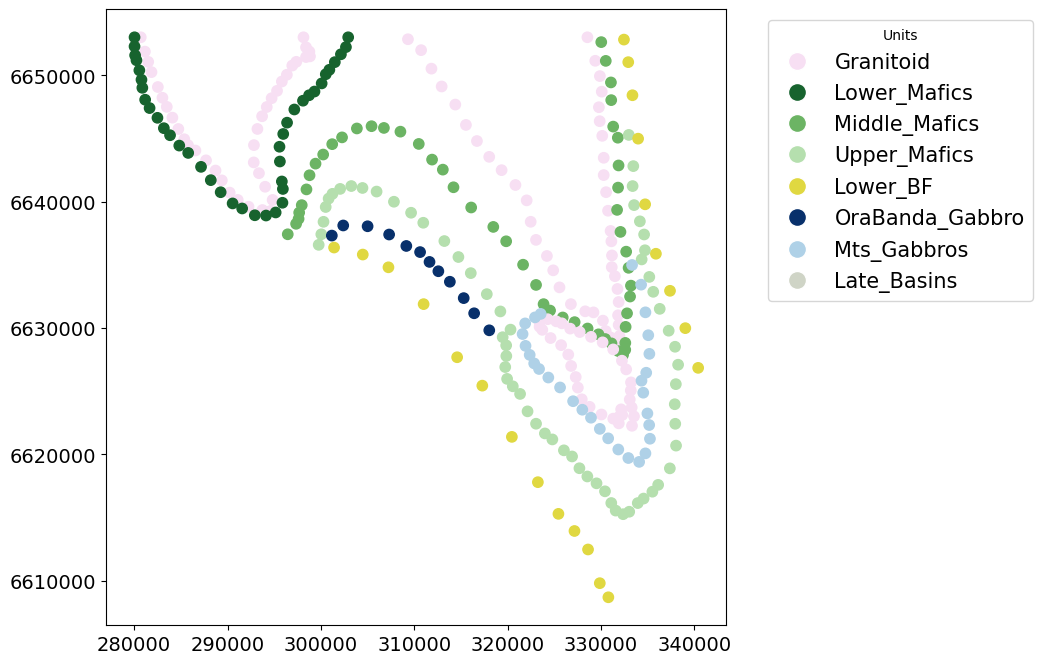

In [9]:
import matplotlib.lines as lin

fig, ax = plt.subplots(figsize=(8, 8))

colors = {'Granitoid':'#f7dff3', 'Lower_Mafics':'#17632e', 'Middle_Mafics':'#6cb464', 'Upper_Mafics':'#b5dfae', 
          'Lower_BF':'#e0d841',  
          'OraBanda_Gabbro':'#08306b', 'Mts_Gabbros':'#afd1e7', 'Late_Basins':'#cfd4c6', }

ax.scatter(contacts.X, contacts.Y, c=contacts.name.map(colors), s = 55)
ax.ticklabel_format(useOffset=False, style = 'plain')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14) # Size here overrides font_prop

# add a legend
handles = [lin.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor=v, label=k, markersize=13) for k, v in colors.items()]

ax.legend(title='Units', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 15)

plt.show()

# 2. Stratigraphic order

In [10]:
#strati_order

order = [
    ("Group_0", ['Lower_BF', 
                 'OraBanda_Gabbro', 
                 'Mts_Gabbros', 
                 'Upper_Mafics', 'Middle_Mafics', 
                 'Lower_Mafics', "Granitoid"])]

order

[('Group_0',
  ['Lower_BF',
   'OraBanda_Gabbro',
   'Mts_Gabbros',
   'Upper_Mafics',
   'Middle_Mafics',
   'Lower_Mafics',
   'Granitoid'])]

# 3. WAROX measurements

In [11]:
ig_lyr = gpd.read_file(
    os.path.join(path_data, "beddings/011_igneous_layering_with_formations.shp")).explode(ignore_index=True, 
                                                                                          index_parts=True)

measurements_df = pd.DataFrame({
    'X': ig_lyr.geometry.x, 
    'Y': ig_lyr.geometry.y,
    'Z': ig_lyr.DEM, 
    'name': ig_lyr.Name, 
    'strike': ig_lyr.STRIKE, 
    'dip':ig_lyr.DIP, 
    'polarity':1
})

In [12]:
beddings = gpd.read_file(
    os.path.join(path_data, "beddings/033_beddings_with_verticals_with_formations.shp")).explode(ignore_index=True, 
                                                                                                 index_parts=True)

measurements_df1 = pd.DataFrame({
    'X': beddings.geometry.x, 
    'Y': beddings.geometry.y,
    'Z': beddings.DEM, 
    'name': beddings.Name, 
    'strike': beddings.STRIKE, 
    'dip': beddings.DIP, 
    'polarity':1
})

In [13]:
met_foliations_s0 = gpd.read_file(
    os.path.join(path_data, "beddings/04_met_foliation_s0_with_formations.shp")).explode(ignore_index=True, 
                                                                                         index_parts=True)

measurements_df2 = pd.DataFrame({
    'X': met_foliations_s0.geometry.x, 
    'Y': met_foliations_s0.geometry.y,
    'Z': met_foliations_s0.DEM, 
    'name': met_foliations_s0.Name, 
    'strike': met_foliations_s0.STRIKE, 
    'dip': met_foliations_s0.DIP, 
    'polarity':1
})

In [14]:
measurements_df = pd.concat([measurements_df, measurements_df1, measurements_df2])

In [15]:
#rename for same names as contacts

In [16]:
# match measurements names with contacts names
measurements_df = measurements_df.replace('Ora Banda Gabbro', 'OraBanda_Gabbro')
measurements_df = measurements_df.replace('Mount_Pleasant_Gabbro', 'Mts_Gabbros')
measurements_df = measurements_df.replace('Mount_Ellis_Gabbro', 'Mts_Gabbros')
measurements_df = measurements_df.replace('Granitoids', 'Granitoid')

In [17]:
measurements_df.isnull().values.any()

False

# 4. Thicknesses

In [18]:
thickness = {
    'Granitoid': 3000,
    'Lower_Mafics': 2238, 
    'Middle_Mafics': 2407, 
    'Upper_Mafics': 3066, 
    'Mts_Gabbros': 1732, 
    'OraBanda_Gabbro': 1575, 
    'Lower_BF': 2349
}

In [19]:
# generate input data for LS with processor

processor = ProcessInputData(
    contacts=contacts,
    contact_orientations=measurements_df,
    thicknesses=thickness,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum, 
    fault_locations = updated_data, 
    fault_orientations = updated_ori
)

                This will result in only a fault surface, no displacement on older features


In [20]:
# add the fold to the processor

fold = gpd.read_file(os.path.join(path_data, "folds/fold.shp"))
fold['X'] = fold.geometry.x
fold['Y'] = fold.geometry.y

import math

strikes = []

for i in range(0, len(fold) - 1):
    x1, y1 = fold['X'][i], fold['Y'][i]
    x2, y2 = fold['X'][i + 1], fold['Y'][i + 1]
    strikes.append(math.degrees(math.atan2((x2 - x1), (y2 - y1))))

strikes.append(338 - 180)
fold['strikes'] = strikes

fold = pd.DataFrame({
    'X': fold['X'],
    'Y': fold['Y'],
    'Z': fold['dem'],
    'strike': fold['strikes'],
    'dip': 90
})

from LoopStructural.utils import strike_dip_vector

fold_df = pd.DataFrame(strike_dip_vector(strike=fold['strike'] + 180,
                                      dip=fold['dip']),
                    columns=['nx', 'ny', 'nz'])

fold['nx'] = fold_df['nx']
fold['ny'] = fold_df['ny']
fold['nz'] = fold_df['nz']

fold['feature_name'] = 's1'
fold['val'] = 0
fold['coord'] = 0

data_test = pd.concat([processor.data, fold])

mx = fold['X'].mean()
my = fold['Y'].mean()
mz = fold['Z'].mean()

a = pd.DataFrame(pd.Series({'X': mx, 
             'Y': my, 
             'Z': mz, 
            'feature_name': 's1',
             'val':1,
             'coord':1})).T

data_test = pd.concat([data_test, a])

In [21]:
# concatenating makes sometimes changes the dtype, this is a checker to make sure it's all in the right format
data_test["X"] = pd.to_numeric(data_test["X"])
data_test["Y"] = pd.to_numeric(data_test["Y"])
data_test["Z"] = pd.to_numeric(data_test["Z"])
data_test["val"] = pd.to_numeric(data_test["val"])
data_test["polarity"] = pd.to_numeric(data_test["polarity"])
data_test["dip"] = pd.to_numeric(data_test["dip"])
data_test["strike"] = pd.to_numeric(data_test["strike"])
data_test["coord"] = pd.to_numeric(data_test["coord"])
data_test["nx"] = pd.to_numeric(data_test["nx"])
data_test["ny"] = pd.to_numeric(data_test["ny"])
data_test["nz"] = pd.to_numeric(data_test["nz"])
data_test["gx"] = pd.to_numeric(data_test["gx"])
data_test["gy"] = pd.to_numeric(data_test["gy"])
data_test["gz"] = pd.to_numeric(data_test["gz"])

In [22]:
model = GeologicalModel(origin = origin, maximum=maximum)
model.data = data_test
model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

model.stratigraphic_column = processor.stratigraphic_column

S1 = model.create_and_add_fold_frame('s1',
                                     nelements=1e4, 
                                     buffer=0.3,
                                     damp=True)

model.update()

ERROR: 2023-05-02 21:50:55,593: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-05-02 21:50:55,594: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-05-02 21:50:55,595: _base_geological_feature.py:73 -- Model not set


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-05-02 21:51:01,603: _geological_feature_builder.py:212 -- Not enough constraints for scalar field add more


[-60058.56537011 -58739.77144139 -57421.02243839 ...  25593.36678836
  26038.59629034  26483.82579233]



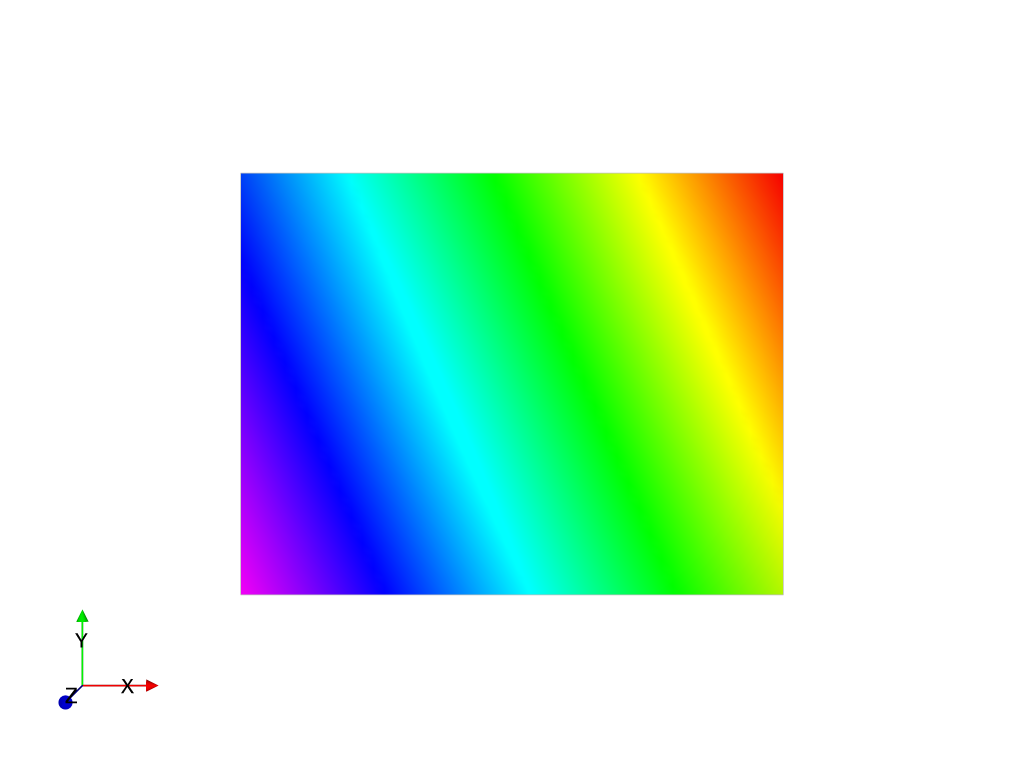

In [23]:
view = LavaVuModelViewer(model)
view.add_scalar_field(S1[0])
view.display()

[0.9589697  0.95491829 0.95087519 ... 1.0937269  1.10089635 1.10806581]



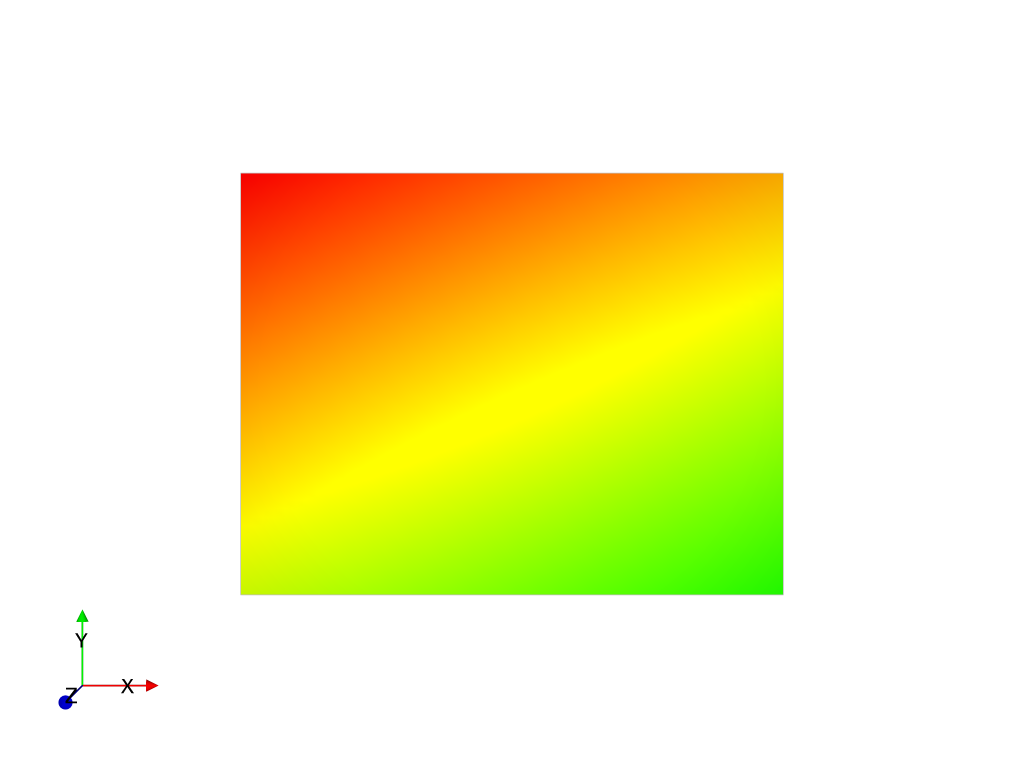

In [24]:
view = LavaVuModelViewer(model)
view.add_scalar_field(S1[1])
view.display()

In [25]:
fold_weights = {'fold_orientation': 10, 
                'fold_axis_w': 10, 
#                 'fold_regularisation': [0.1, 0.1, .1], 
                'fold_normalisation': 0.1, 
                'fold_norm': 2.5, #length of the norm
                'step': 150}

S0 = model.create_and_add_folded_foliation('Group_0',
                                            limb_wl= 20000, 
                                            fold_frame=S1,
                                            fold_weights = fold_weights,
                                            av_fold_axis=True, # 
                                            nelements=1e4,
                                            buffer = 0.1, 
                                            solver='cg', 
                                            cpw = 0.1, npw = 0.1
                                           )
model.update()

  0%|          | 0/4 [00:00<?, ?it/s]

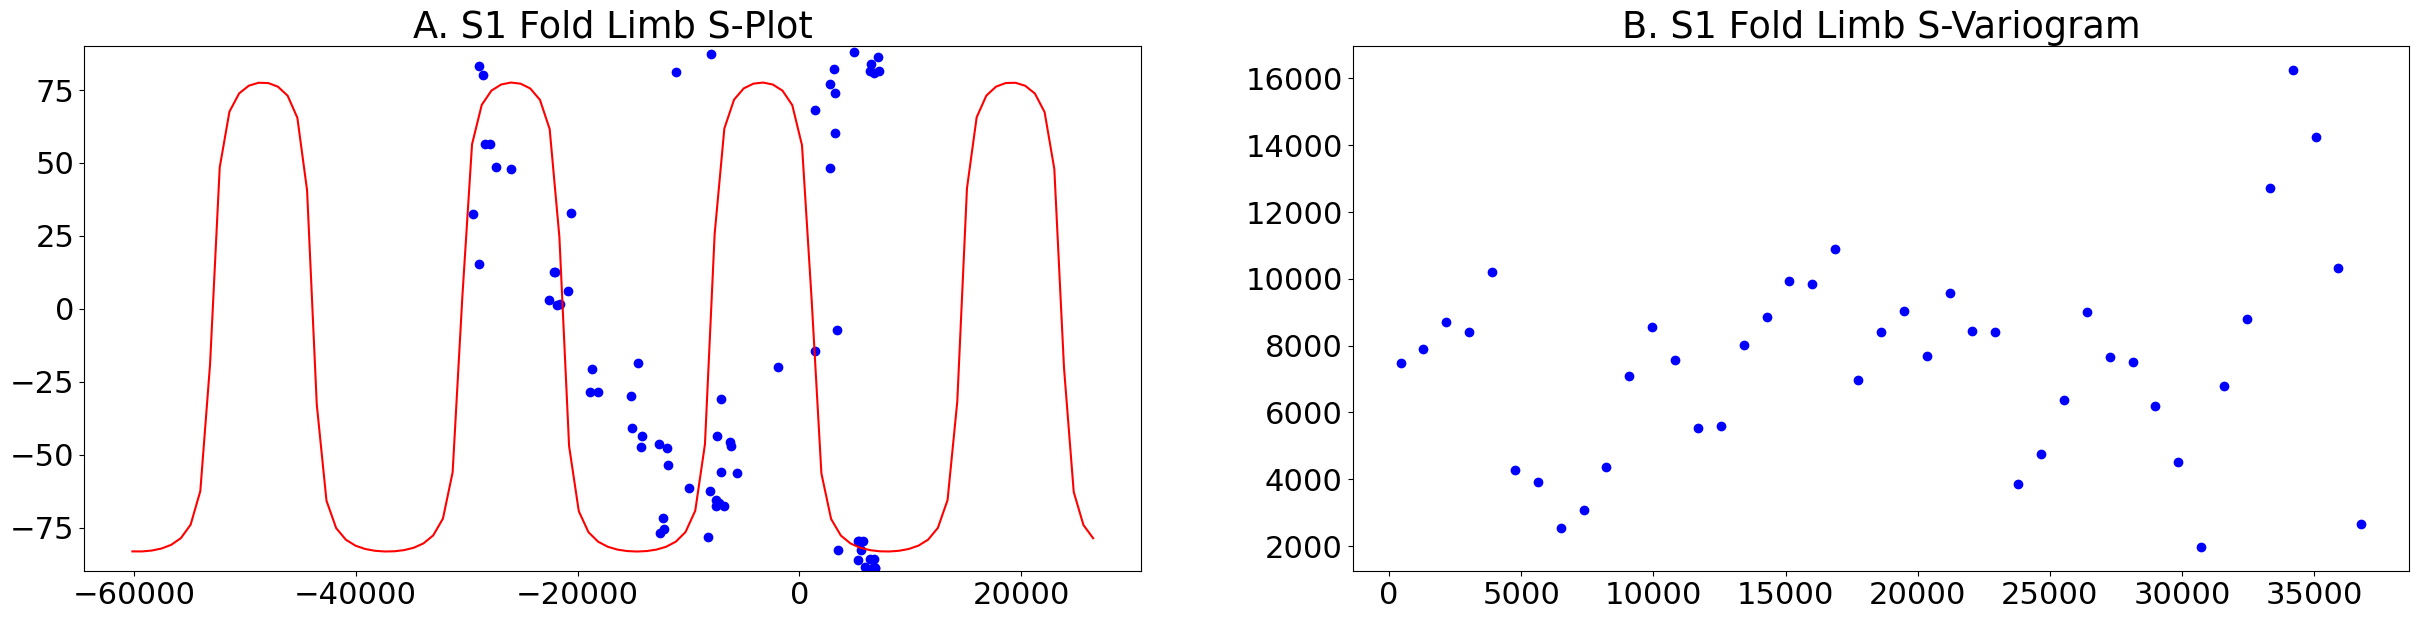

In [26]:
plt.rcParams.update({'font.size': 22})
S0.fold.foldframe[0].set_model(model)

S1_S0_splot = RotationAnglePlotter(S0)
S1_S0_splot.add_fold_limb_data()
S1_S0_splot.add_fold_limb_curve() 
S1_S0_splot.add_limb_svariogram()#fold_limb_
S1_S0_splot.ax[1,0].set_title('A. S1 Fold Limb S-Plot')
S1_S0_splot.ax[1,1].set_title('B. S1 Fold Limb S-Variogram')

S1_S0_splot.fig.delaxes(S1_S0_splot.ax[0][0])
S1_S0_splot.fig.delaxes(S1_S0_splot.ax[0][1])


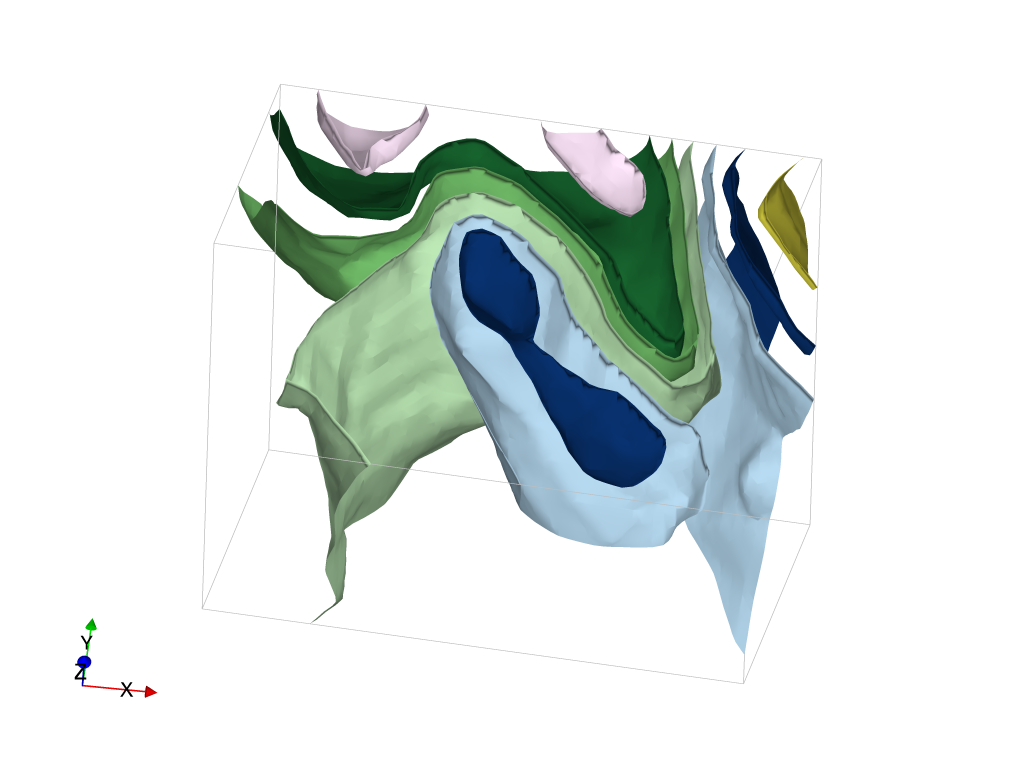

In [27]:
view = LavaVuModelViewer(model)

view.nelements = 1e5
all_names = []
all_values = []

# view.nsteps = [50,50,300]

colores = [['#f7dff3'], 
           ['#17632e'], 
           ['#6cb464'],
           ['#b5dfae'], 
           ['#afd1e7'], 
           ['#08306b'], 
           ['#e0d841'],      
           ]


for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
    
# view.add_data(model['Group_0'])
# view.add_fold(model['Group_0'].fold, locations = model.regular_grid()[::100, :])

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
view.display()
# view.interactive()

# remove vals above 75 degrees from warox

In [28]:
# remove 90degrees values
measurements_df = measurements_df.reset_index(drop=True)
measurements_df = measurements_df[measurements_df['dip']<75]
measurements_df = measurements_df[measurements_df['dip']!=-99]
measurements_df = measurements_df.reset_index(drop=True)

In [29]:
processor = ProcessInputData(
    contacts=contacts,
    contact_orientations=measurements_df,
    thicknesses=thickness,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum, 
    fault_locations = updated_data, 
    fault_orientations = updated_ori
)

                This will result in only a fault surface, no displacement on older features


In [30]:
# add the fold to the processor

fold = gpd.read_file(os.path.join(path_data, "folds/fold.shp"))
fold['X'] = fold.geometry.x
fold['Y'] = fold.geometry.y

import math

strikes = []

for i in range(0, len(fold) - 1):
    x1, y1 = fold['X'][i], fold['Y'][i]
    x2, y2 = fold['X'][i + 1], fold['Y'][i + 1]
    strikes.append(math.degrees(math.atan2((x2 - x1), (y2 - y1))))

strikes.append(338 - 180)
fold['strikes'] = strikes

fold = pd.DataFrame({
    'X': fold['X'],
    'Y': fold['Y'],
    'Z': fold['dem'],
    'strike': fold['strikes'],
    'dip': 90
})

from LoopStructural.utils import strike_dip_vector

fold_df = pd.DataFrame(strike_dip_vector(strike=fold['strike'], #+ 180,
                                         dip=fold['dip']),
                    columns=['nx', 'ny', 'nz'])

fold['nx'] = fold_df['nx']
fold['ny'] = fold_df['ny']
fold['nz'] = fold_df['nz']

fold['feature_name'] = 's1'
fold['val'] = 0
fold['coord'] = 0

data_test = pd.concat([processor.data, fold])

mx = fold['X'].mean()
my = fold['Y'].mean()
mz = fold['Z'].mean()

a = pd.DataFrame(pd.Series({'X': mx, 
             'Y': my, 
             'Z': mz, 
            'feature_name': 's1',
             'val':1,
             'coord':1})).T

data_test = pd.concat([data_test, a])

In [31]:
fold

,X,Y,Z,strike,dip,nx,ny,nz,feature_name,val,coord
0,322193.371150,6.650779e+06,378.98,156.727880,90,-0.918639,-0.395099,6.123234e-17,s1,0,0
1,324762.461000,6.644806e+06,387.00,158.233384,90,-0.928702,-0.370827,6.123234e-17,s1,0,0
2,326824.098053,6.639642e+06,399.00,154.976685,90,-0.906136,-0.422987,6.123234e-17,s1,0,0
3,331340.415600,6.629967e+06,441.96,158.000000,90,-0.927184,-0.374607,6.123234e-17,s1,0,0


In [32]:
model = GeologicalModel(origin = origin, maximum=maximum)
model.data = data_test
model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 
model.nsteps= [100,100,100]
model.stratigraphic_column = processor.stratigraphic_column

S1 = model.create_and_add_fold_frame('s1',
                                     nelements=1e4, 
                                     buffer=0.3,
                                     damp=True)

model.update()


ERROR: 2023-05-02 21:51:05,926: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-05-02 21:51:05,927: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-05-02 21:51:05,928: _base_geological_feature.py:73 -- Model not set


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-05-02 21:51:10,446: _geological_feature_builder.py:212 -- Not enough constraints for scalar field add more


  0%|          | 0/4 [00:00<?, ?it/s]

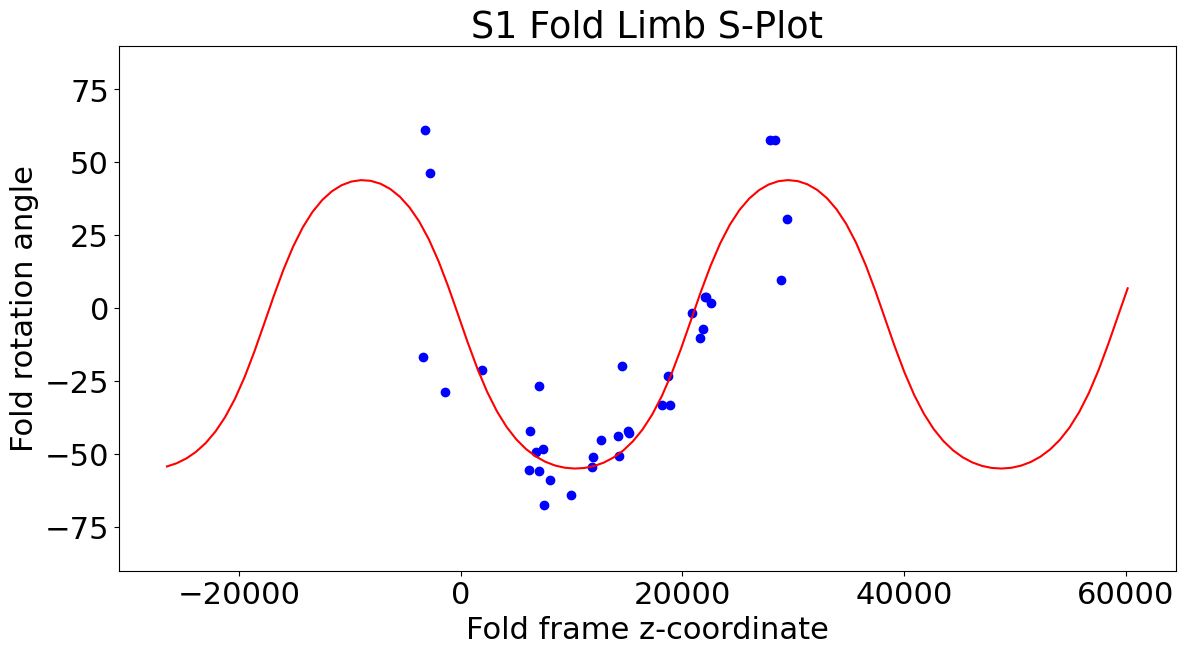

In [33]:
fold_weights = {'fold_orientation': 10, 
                'fold_axis_w': 10, 
#                 'fold_regularisation': [0.1, 0.1, .1], 
                'fold_normalisation': 0.02, 
                'fold_norm': 2.5, #length of the norm
                'step': 150}

S0 = model.create_and_add_folded_foliation('Group_0',
                                            limb_wl= 25000, 
                                            fold_frame=S1,
                                            fold_weights = fold_weights,
                                           fold_axis = [0.54, -0.77 ,-0.34 ],
#                                             av_fold_axis=True, # 
                                            nelements=1e4,
                                            buffer = 0.1, 
                                            solver='cg', 
                                            cpw = 0.2, npw = 0.1
                                           )
model.update()

plt.rcParams.update({'font.size': 22})
S0.fold.foldframe[0].set_model(model)

S1_S0_splot = RotationAnglePlotter(S0)
S1_S0_splot.add_fold_limb_data()
S1_S0_splot.add_fold_limb_curve() 
S1_S0_splot.add_limb_svariogram()#fold_limb_
S1_S0_splot.ax[1,0].set_title('S1 Fold Limb S-Plot')
S1_S0_splot.ax[1,0].set_xlabel('Fold frame z-coordinate')
S1_S0_splot.ax[1,0].set_ylabel('Fold rotation angle')

S1_S0_splot.fig.delaxes(S1_S0_splot.ax[1][1])
S1_S0_splot.fig.delaxes(S1_S0_splot.ax[0][0])
S1_S0_splot.fig.delaxes(S1_S0_splot.ax[0][1])

In [34]:
S0.fold.fold_axis

array([ 0.54, -0.77, -0.34])

Object exists: k
[ 60058.57743975  59405.8411605   58753.10488125 ... -26043.09177974
 -26263.45797085 -26483.82416197]



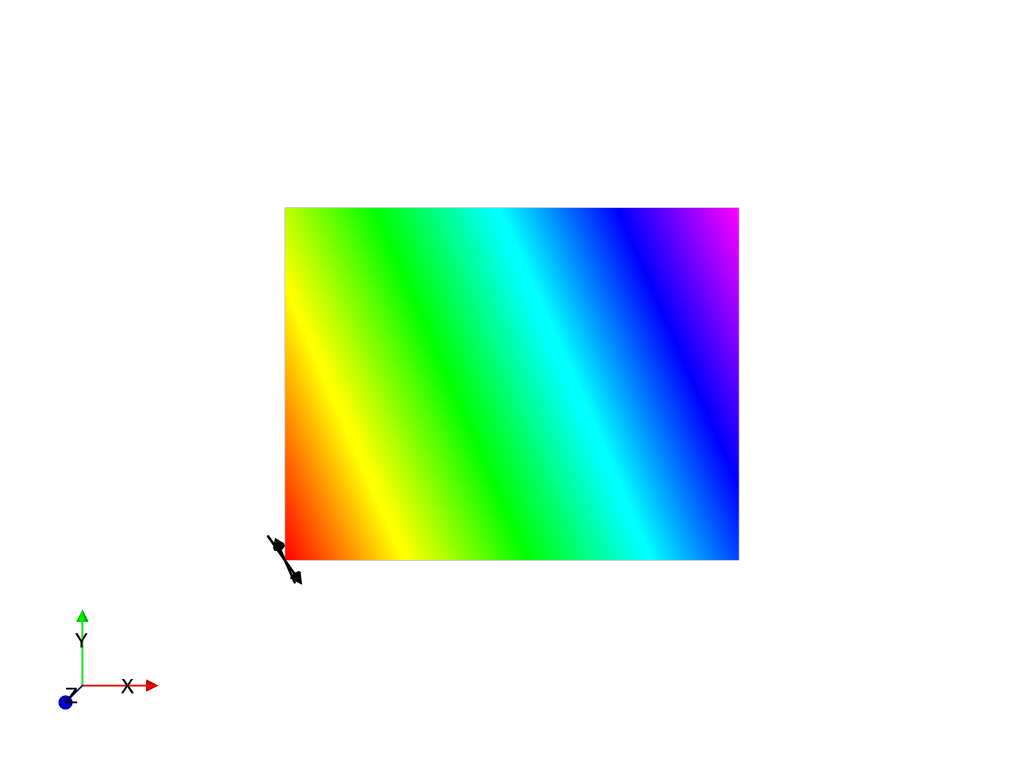

In [35]:
view = LavaVuModelViewer(model)
view.add_vector_data(location = np.array([278590.22261910175, 6598684.856697097, 40000]).reshape(1,3), 
                     vector =  np.array([ 0.54, -0.77, -0.34]).reshape(1,3), name='k')
view.add_vector_data(location = np.array([278590.22261910175, 6598684.856697097, 40000]).reshape(1,3), 
                     vector =  np.array([-0.286944  ,  0.65372668,  0.59015923]).reshape(1,3), name='k')
view.add_scalar_field(S1[0])

view.display()


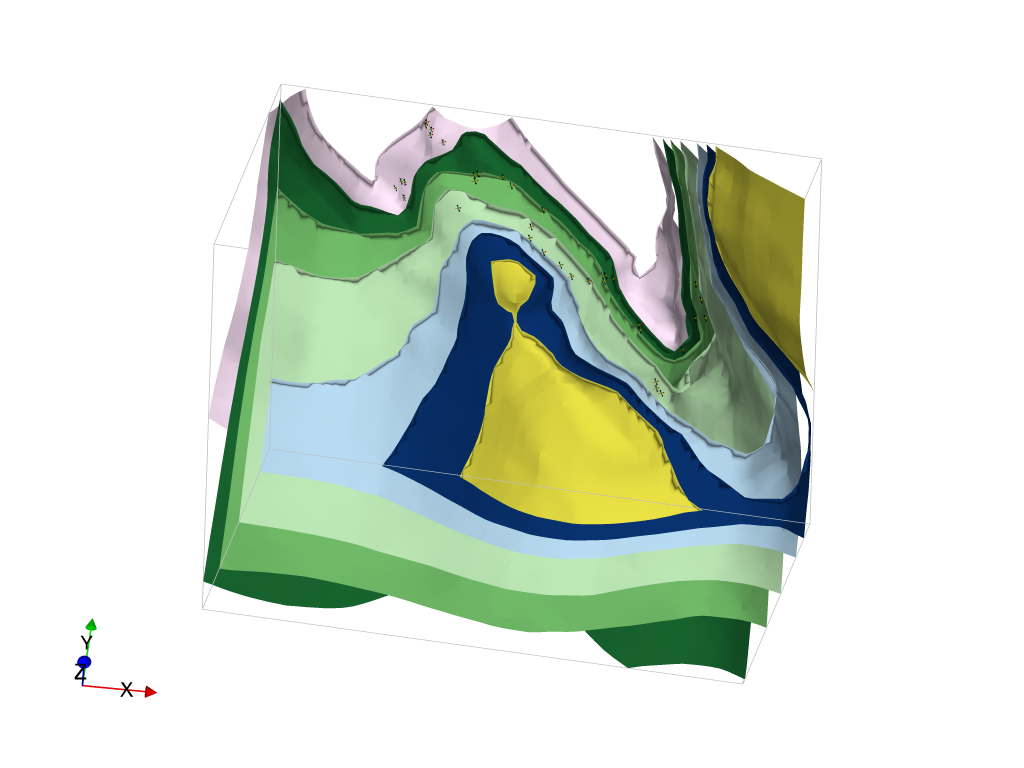

In [36]:
view = LavaVuModelViewer(model)

view.nelements = 1e5
all_names = []
all_values = []

# view.nsteps = [100,100,100]

colores = [['#f7dff3'], 
           ['#17632e'], 
           ['#6cb464'],
           ['#b5dfae'], 
           ['#afd1e7'], 
           ['#08306b'], 
           ['#e0d841'],      
           ]

for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
# view.add_data(model['Group_0'], vectors=True, disks=False)
# view.add_data(model['Group_0'])
# view.add_fold(model['Group_0'].fold, locations = model.regular_grid()[::100, :])

view.add_vector_data(location = model.rescale(
                     S0.builder.get_norm_constraints()[:, 0:3]), 
                     vector = S1.calculate_intersection_lineation(S0.builder), name = 'f') #intersection lineation

view.add_fold(S0.builder.fold, locations = S0.builder.get_norm_constraints()[:, 0:3])

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
view.display()
# view.interactive()

In [38]:
S1.calculate_intersection_lineation(S0.builder)

array([[-0.29133096,  0.67065658,  0.68216275],
       [-0.34256481,  0.79238516,  0.50475251],
       [-0.36194252,  0.83202775,  0.42038961],
       [-0.33737569,  0.77845235,  0.52932937],
       [-0.35424982,  0.80971008,  0.46784255],
       [-0.36928028,  0.84029021,  0.39691868],
       [-0.2047579 ,  0.46016083,  0.86390174],
       [-0.30278345,  0.68155178,  0.66619018],
       [-0.26804579,  0.62112256,  0.73644974],
       [-0.14687781,  0.32001727,  0.93595719],
       [-0.19712484,  0.44312455,  0.8745184 ],
       [-0.34969187,  0.79863355,  0.48979592],
       [-0.15306974,  0.35091611,  0.92381142],
       [-0.326178  ,  0.75149194,  0.57346995],
       [-0.29134984,  0.67065553,  0.68215572],
       [-0.35239466,  0.79076717, -0.50050503],
       [-0.39028736,  0.88893438,  0.23973202],
       [-0.20011682,  0.458331  ,  0.86595955],
       [-0.13735068,  0.31331793,  0.93966306],
       [-0.20670218,  0.47233619,  0.8568388 ],
       [-0.35652306,  0.81388124,  0.458

In [39]:
S0.builder.get_norm_constraints()[:, 0:3]

array([[26224.1524367 , 45967.97348128, 40456.96      ],
       [30653.8801414 , 44859.9253156 , 40426.        ],
       [23818.91003465, 40350.5906317 , 40437.89      ],
       [33315.60693113, 37304.95939513, 40473.        ],
       [35164.18943427, 35432.5920853 , 40468.        ],
       [37478.17983625, 33874.49231792, 40440.        ],
       [55308.88462592, 33815.06549368, 40459.83      ],
       [38969.18652563, 32397.50910625, 40433.        ],
       [56086.09485131, 31587.13717838, 40419.18      ],
       [55367.80118691, 28675.95645807, 40399.15      ],
       [47947.08070566, 26498.65264599, 40410.        ],
       [53875.02957065, 23635.95020881, 40392.        ],
       [29522.43843931, 46017.00861126, 40443.95      ],
       [25769.67088212, 45608.53311286, 40454.18      ],
       [25896.76097917, 44824.47354897, 40443.12      ],
       [44430.16896849, 32868.45653435, 40445.        ],
       [48172.77075714, 25715.594494  , 40400.        ],
       [19271.00679084, 52675.6

# Add faults

In [37]:
# concatenating makes sometimes changes the dtype, this is a checker to make sure it's all in the right format
data_test["X"] = pd.to_numeric(data_test["X"])
data_test["Y"] = pd.to_numeric(data_test["Y"])
data_test["Z"] = pd.to_numeric(data_test["Z"])
data_test["val"] = pd.to_numeric(data_test["val"])
data_test["polarity"] = pd.to_numeric(data_test["polarity"])
data_test["dip"] = pd.to_numeric(data_test["dip"])
data_test["strike"] = pd.to_numeric(data_test["strike"])
data_test["coord"] = pd.to_numeric(data_test["coord"])
data_test["nx"] = pd.to_numeric(data_test["nx"])
data_test["ny"] = pd.to_numeric(data_test["ny"])
data_test["nz"] = pd.to_numeric(data_test["nz"])
data_test["gx"] = pd.to_numeric(data_test["gx"])
data_test["gy"] = pd.to_numeric(data_test["gy"])
data_test["gz"] = pd.to_numeric(data_test["gz"])

In [51]:
model = GeologicalModel(origin = origin, maximum=maximum)
model.data = data_test
model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 
model.stratigraphic_column = processor.stratigraphic_column

model.nsteps = [50, 50, 100]

S1 = model.create_and_add_fold_frame('s1',
                                     nelements=1e4, 
                                     buffer=0.3,
                                     damp=True)

fold_weights = {'fold_orientation': 10, 
                'fold_axis_w': 10, 
#                 'fold_regularisation': [0.1, 0.1, .1], 
                'fold_normalisation': 0.1, 
                'fold_norm': 2.5, #length of the norm
                'step': 150}

S0 = model.create_and_add_folded_foliation('Group_0',
                                            limb_wl= 25000, 
                                            fold_frame=S1,
                                            fold_weights = fold_weights,
                                           fold_axis = [0.54, -0.77 ,-0.34],
#                                             av_fold_axis=True, # 
                                            nelements=1e4,
                                            buffer = 0.1, 
                                            solver='cg', 
                                            cpw = 0.2, npw = 0.1
                                           )

model.create_and_add_fault('Zuleika Fault', displacement = 0, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Black Flag Fault', displacement = 0, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('F1', displacement = 0, nelements=1e4, force_mesh_geometry = True)
model['F1'].builder.set_mesh_geometry(0.1, 0)
model.create_and_add_fault('Boorara Fault', displacement = 0, nelements=1e4, force_mesh_geometry = True), 
tang1 = np.tile([-1737.07, -2023.51,  7009.83],
                (model['Black Flag Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Black Flag Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Black Flag Fault'][0].interpolator.support.barycentre,
                vector = tang1, w=1, B=0)

# model.create_and_add_foliation('Zuleika Fault', nelements=1e4, force_mesh_geometry = True)
# model.add_unconformity(model["Zuleika Fault"], 0.0)

model.update()

ERROR: 2023-05-02 22:02:11,052: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-05-02 22:02:11,053: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-05-02 22:02:11,053: _base_geological_feature.py:73 -- Model not set


  0%|          | 0/16 [00:00<?, ?it/s]

ERROR: 2023-05-02 22:02:17,158: _geological_feature_builder.py:212 -- Not enough constraints for scalar field add more



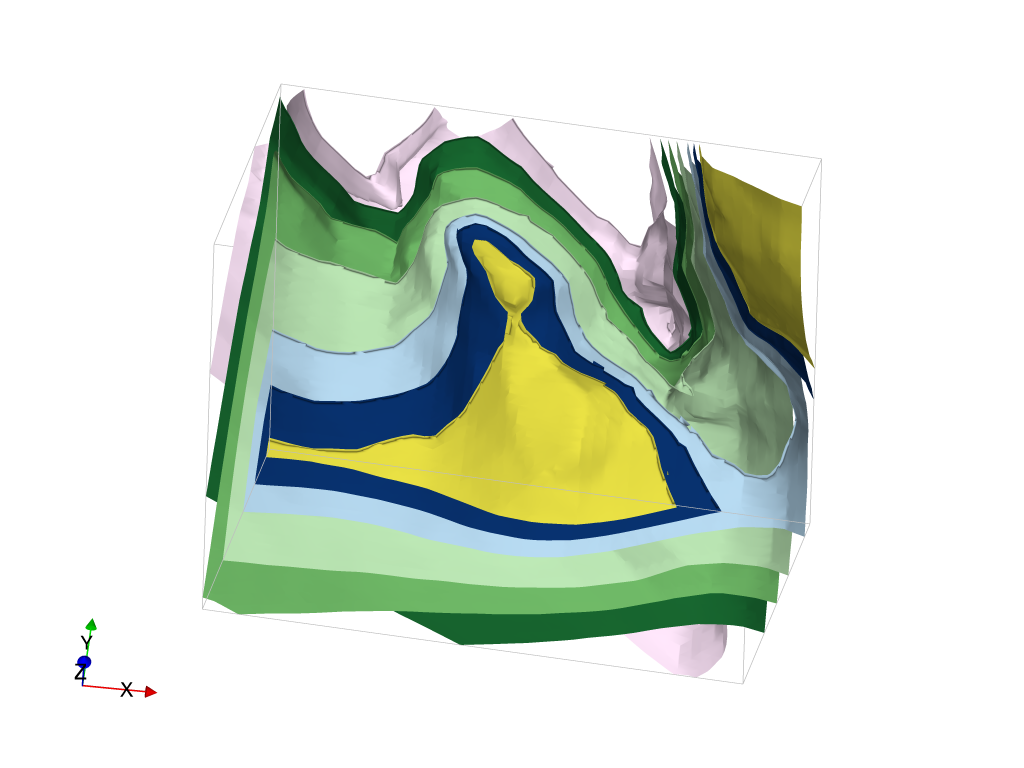

In [52]:
view = LavaVuModelViewer(model)

# view.nelements = 4e6
all_names = []
all_values = []

# view.nsteps = [150, 150, 150]

colores = [['#f7dff3'], 
           ['#17632e'], 
           ['#6cb464'],
           ['#b5dfae'], 
           ['#afd1e7'], 
           ['#08306b'], 
           ['#e0d841'],      
           ]

for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
    
# view.add_data(model['Boorara Fault'])
# view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
# view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
# view.add_isosurface(model['Zuleika Fault']
#                     , colours = ['#fb9a99'],value=0)
# view.add_isosurface(model['F1'], colours = ['#a6cee3'], value = 0)

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
view.display();
# view.interactive()

Object exists: Boorara Fault_value_cp
Object exists: Boorara Fault_value_cp



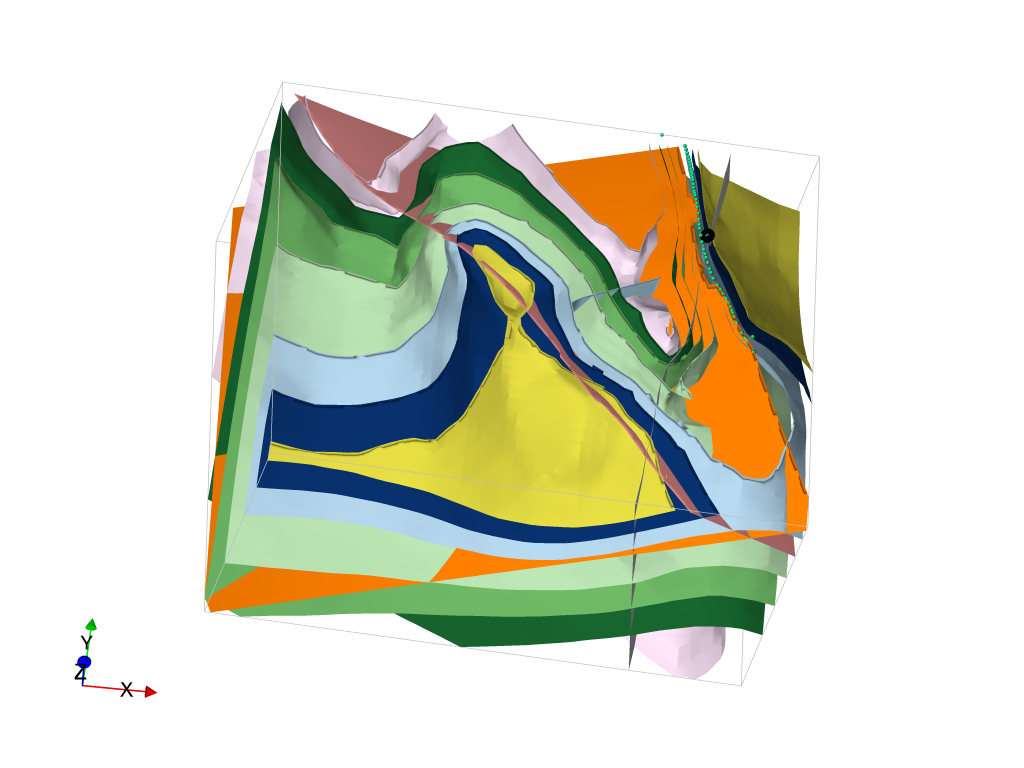

In [53]:
view = LavaVuModelViewer(model)

# view.nelements = 4e6

all_names = []
all_values = []

# view.nsteps = [150, 150, 150]

colores = [['#f7dff3'], 
           ['#17632e'], 
           ['#6cb464'],
           ['#b5dfae'], 
           ['#afd1e7'], 
           ['#08306b'], 
           ['#e0d841'],      
           ]

for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
    
view.add_data(model['Boorara Fault'])
view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Zuleika Fault']
                    , colours = ['#fb9a99'],value=0)
view.add_isosurface(model['F1'], colours = ['#a6cee3'], value = 0)

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
view.display();
# view.interactive()

In [54]:
view.export_to_webgl('outputs/model_with_fold_frame_final_version_.html')

In [55]:
from LoopStructural.export.file_formats import FileFormat
from LoopStructural.export import exporters

In [56]:
for j in range(0, len(all_names)):
    exporters.write_feat_surfs(model=model, featurename = 'Group_0',
                           file_format=FileFormat.VTK, 
                           isovalue = all_values[j],
                           file_name = "./outputs/VTK/{}.vtk".format(all_names[j]))

In [57]:
all_values

[0, 3000.0, 5238.0, 7645.0, 10711.0, 12443.0, 14018.0]

In [58]:
all_names

['Granitoid',
 'Lower_Mafics',
 'Middle_Mafics',
 'Upper_Mafics',
 'Mts_Gabbros',
 'OraBanda_Gabbro',
 'Lower_BF']

In [ ]:
exporters.write_feat_surfs(model=model, featurename = 'Zuleika Fault',
                       file_format=FileFormat.VTK, 
                       isovalue = all_values[j],
                       file_name = "./outputs/VTK/{}.vtk".format(all_names[j]))